In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')
device

device(type='cuda', index=0)

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '../Dataset/Compiled/Classification/'
nclasses   = 9

# Set the desired image size for rescaling and maximum value for normalization

width       = 341 
height      = 256
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.40
valid_perc = 0.30
test_perc  = 0.30

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = int(len(data)*test_perc)
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

# Set output model name

model_name  = 'FishDNNPre.pth'

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("\\")[-1].split("_")[0]) for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target) 

In [4]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

Number of images: 3600

Images are 341x256x3

Class of the image:  1

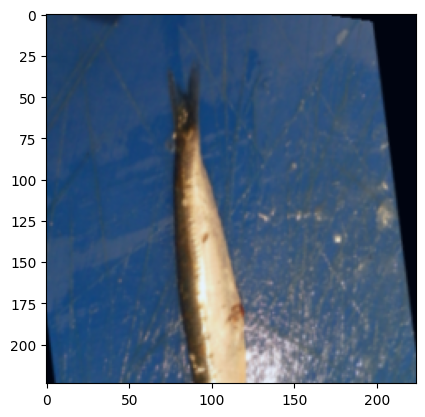

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[10] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

In [6]:
batchsize = 50
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

══════════════════════════════════════════════════════════════════

list of 2 items

Tensor  Shape: torch.Size([50, 3, 224, 224])    Min: -2.118     Max: 2.623      Mean: -0.207    dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([50]) Min: 0.000      Max: 8.000      Mean: 4.100     dtype: torch.int64 @ cpu

══════════════════════════════════════════════════════════════════

In [7]:
def Criterion(preds, targets):
    ce = nn.CrossEntropyLoss().to(device)
    loss = ce(preds, targets.long())
    # compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1]  # same as argmax
    acc = torch.sum(pred_labels == targets.data) / pred_labels.size(0)
    return loss, acc


def CorelVGG(nclasses):
    # get the vgg16 model pretrained on ImageNet
    model = models.vgg16(weights="IMAGENET1K_V1")
    # Specify you do not want to train the parameters of the model
    for param in model.parameters():
        param.requires_grad = False
    # The vgg16 model consists of three modules: features, avgpool, and classifier.
    # Change avgpool to return a feature map of size 1x1 instead of 7x7. This will create
    # batches with 512x1x1 tensors.
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    # Change the classifier to one suitable for your dataset
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, nclasses),
    )  # you do not need nn.Softmax() in torch
    criterion = Criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Return the complete model information for training and evaluation
    return (model.to(device), criterion, optimizer)


model, criterion, optimizer = CorelVGG(nclasses)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [8]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    return loss.item(), acc.item()       

In [9]:
# initializing variables
n_epochs = 5
log = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        # report results for the batch
        log.record((ex + (bx + 1) / N), trn_loss=loss, trn_acc=acc, end="\r")

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex + (bx + 1) / N), val_loss=loss, val_acc=acc, end="\r")

    if (ex + 1) % 2 == 0:
        log.report_avgs(ex + 1)

EPOCH: 2.000  trn_loss: 0.282  val_loss: 0.156  trn_acc: 0.959  val_acc: 0.974  (134.78s - 202.16s remaining)
EPOCH: 4.000  trn_loss: 0.089  val_loss: 0.084  trn_acc: 0.986  val_acc: 0.980  (268.16s - 67.04s remaining)
EPOCH: 5.000  val_loss: 0.104  val_acc: 0.940  (334.91s - 0.00s remaining))

100%|██████████| 106/106 [00:00<00:00, 17666.54it/s]


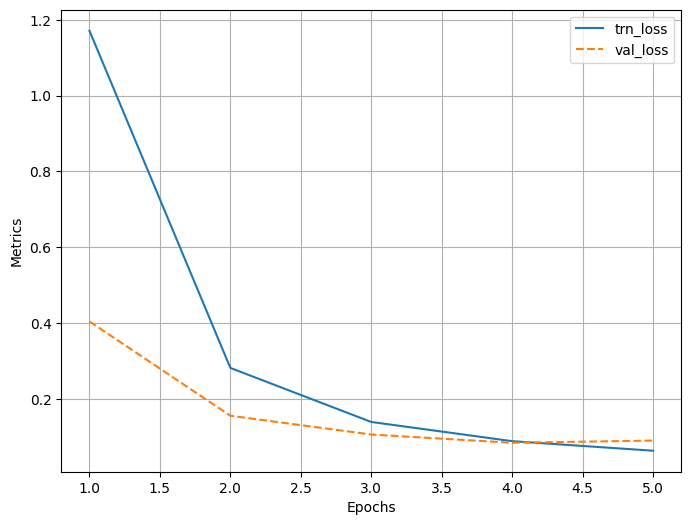

100%|██████████| 106/106 [00:00<00:00, 13244.64it/s]


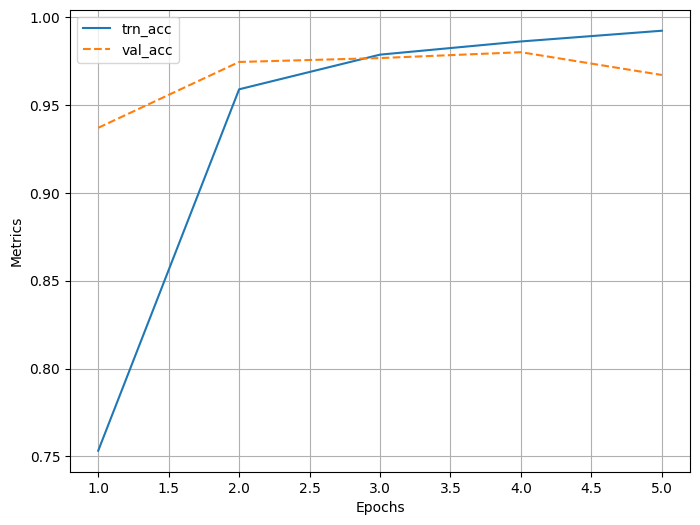

In [10]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

In [ ]:
def get_activations(model, x, device):
    # move input tensor x to the selected device
    x = x.to(device)

    return model.features[-1](x)


def get_output_of_the_model(model, x, device):
    # put the model in the evaluation mode
    model.eval()
    # move input tensor x to the selected device
    x = x.to(device)
    # execute the model with gradients
    output = model(x)
    return output


def get_heatmap(model, x, device, model_name, labels_map):
    # add one dimension (dim=0 must be the number of images)
    xin = x.unsqueeze(0)

    # get the output of the feature extractor
    activ = get_activations(model, xin, device)

    # get the predictions at the output of the decision layer
    logits = get_output_of_the_model(model, xin, device)

    # get the most confident prediction
    pred = logits.max(-1)[-1]
    print("predicted label: ", labels_map[pred.cpu().detach().numpy()[0]])

    # compute gradients with respect to the most confident prediction
    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)

    print(activ.shape)
    # only conv2D generates gradients in the feature extractor: extracts them.
    for layer_name, layer in model.features[0].named_children():
        if layer_name == "0":
            grad1 = layer.weight.grad
            nchannels1 = grad1.shape[0]
            # compute the weighted mean of the activations across channels using the mean value of the gradient
            # of each filter parameter as weight.
            for i in range(16):
                activ[:, i, :, :] *= grad1[i].mean()
    for layer_name, layer in model.features[1].named_children():
        if layer_name == "0":
            grad2 = layer.weight.grad
            nchannels2 = grad2.shape[0]
            for i in range(64):
                activ[:, i + 16, :, :] *= grad2[i].mean()

    for layer_name, layer in model.features[2].named_children():
        if layer_name == "0":
            grad3 = layer.weight.grad
            nchannels3 = grad3.shape[0]
            for i in range(64):
                activ[:, i + 16, :, :] *= grad3[i].mean()

    heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

    # convert to numpy, normalize, and resize to the input size
    heatmap = heatmap.squeeze(0).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
    return heatmap


def display_image_with_heatmap(img, heatmap, scale):
    heatmap = np.uint8(255.0 * heatmap)
    width = int(heatmap.shape[1] * scale)
    height = int(heatmap.shape[0] * scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255 - heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap * 0.7 + img * 0.3)
    plt.imshow(heatmap)
    plt.show()